## Yelp Sentiment Analysis
This notebook goes through the process of classifying user's review into positive or negative sentiments using basic data preprocessing and single perceptron. The code here is based on this book *Build Intelligent Language Applications Using Deep Learning* 

Reference: https://www.oreilly.com/library/view/natural-language-processing/9781491978221/

In [2]:
import collections
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from torch import nn
from argparse import Namespace


In [3]:
args = Namespace(
    raw_train_dataset_csv="data/yelp/raw_train.csv",
    raw_test_dataset_csv="data/yelp/raw_test.csv",
    proportion_subset_of_train=0.1,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/yelp/reviews_with_splits_lite.csv",
    seed=2021
)

In [4]:
train_reviews = pd.read_csv(args.raw_train_dataset_csv, header=None, names=['rating', 'review'])

In [5]:
train_reviews.head()

,rating,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [6]:
# making the subset equal across the review classes

# dict with 2 keys either 1 or 2
# each key holds list of the corresponding reviews
by_rating = collections.defaultdict(list)
for _, row in train_reviews.iterrows():
    by_rating[row.rating].append(row.to_dict())
    


In [7]:
len(by_rating.items())

2

In [8]:
by_rating[1][120]

{'rating': 1,
 'review': 'Poor service and food. I waited 20 minutes at the bar for someone to just acknowledge my presence. They finally brought my food out and left it without asking for me to pay.... So I had to wait an additional 15 minutes to find someone to pay. Yes, I had to TRY and give them money.\\n\\nOn to the important part... Food was terrible. I had a burger and it was pathetic.'}

In [9]:
#taking subset from the training data 10%
review_subset = []

for _, item_list in sorted(by_rating.items()):

    n_total = len(item_list)
    n_subset = int(args.proportion_subset_of_train * n_total)
    review_subset.extend(item_list[:n_subset])

review_subset = pd.DataFrame(review_subset)

In [10]:
review_subset.head()

,rating,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,1,I don't know what Dr. Goldberg was like before...
2,1,I'm writing this review to give you a heads up...
3,1,Wing sauce is like water. Pretty much a lot of...
4,1,Owning a driving range inside the city limits ...


In [11]:
review_subset.rating.value_counts()

2    28000
1    28000
Name: rating, dtype: int64

In [12]:
# Split the subset by rating to create new train, val, and test splits
by_rating = collections.defaultdict(list)
for _, row in review_subset.iterrows():
    by_rating[row.rating].append(row.to_dict())
# Create split data
final_list = []
np.random.seed(args.seed)


for _, item_list in sorted(by_rating.items()):
    np.random.shuffle(item_list)
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'
# Add to final list
    final_list.extend(item_list)
final_reviews = pd.DataFrame(final_list)

In [13]:
final_reviews.head()

,rating,review,split
0,1,Well if there was zero I would give that as my...,train
1,1,I took my cat to this hospital because he dev...,train
2,1,"I have never gotten the correct order here, an...",train
3,1,This is the worst Pizza Hut that I have ever o...,train
4,1,This hotel is disgusting. First of all I.made...,train


In [14]:
final_reviews.split.value_counts()

train    39200
val       8400
test      8400
Name: split, dtype: int64

# Basic data cleaning

    1) lowering reviews
    2) any punctuation . , ! ? surround with  space
    3) any other puctuation other than the mentioned above replace with space

In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
final_reviews.review = final_reviews.review.apply(preprocess_text)

In [16]:
final_reviews.head()
final_reviews.to_csv(args.output_munged_csv, index=False)

In [17]:
final_reviews['rating'] = final_reviews.rating.apply({1: 'negative', 2: 'positive'}.get)

In [18]:
final_reviews.head()

,rating,review,split
0,negative,well if there was zero i would give that as my...,train
1,negative,i took my cat to this hospital because he deve...,train
2,negative,"i have never gotten the correct order here , a...",train
3,negative,this is the worst pizza hut that i have ever o...,train
4,negative,this hotel is disgusting . first of all i . ma...,train


In [19]:
final_reviews.to_csv(args.output_munged_csv, index = False)

# Dataset Loader

In [20]:
from torch.utils.data import DataLoader, Dataset

In [21]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size 

In [22]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# Vocublary

In this class we are mapping each unique token with index

In [23]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

# Vectorizer

The aim of the class is to create one-hot vector that represents each review, all the vectors are of the same size (our vocab len)

In [24]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hit vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

# Perceptron classifier


In [25]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

In [26]:
from argparse import Namespace
args = Namespace(
        # Data and path information
        frequency_cutoff=25,
        model_state_file='model.pth',
        review_csv='data/yelp/reviews_with_splits_lite.csv',
        save_dir='model_storage/',
        #vectorizer_file='vectorizer.json',
        # No model hyperparameters
        # Training hyperparameters
        batch_size=128,
        early_stopping_criteria=5,
        learning_rate=0.001,
        num_epochs=23,
        seed=2021,
        cuda = True
)

In [27]:
import torch.optim as optim
from collections import Counter
import string
import torch

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


train_state = make_train_state(args)
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
# dataset and vectorizer
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
vectorizer = dataset.get_vectorizer()


# model
classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))
classifier = classifier.to(args.device)

# loss and optimizer

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

In [28]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

# Training Loop

In [29]:
for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    # Iterate over training dataset

    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()
    
    print('epoch', epoch_index)

    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is these 5 steps:

        # --------------------------------------
        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        # -----------------------------------------
        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

        # update bar
#         train_bar.set_postfix(loss=running_loss, 
#                               acc=running_acc, 
#                               epoch=epoch_index)
#         train_bar.update()


    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Iterate over val dataset

    # setup: batch generator, set loss and acc to 0; set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):

        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

#         val_bar.set_postfix(loss=running_loss, 
#                             acc=running_acc, 
#                             epoch=epoch_index)
#         val_bar.update()

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

#     train_state = update_train_state(args=args, model=classifier,
#                                      train_state=train_state)

#     scheduler.step(train_state['val_loss'][-1])

#     train_bar.n = 0
#     val_bar.n = 0
#     epoch_bar.update()

#     if train_state['stop_early']:
#         break

#     train_bar.n = 0
#     val_bar.n = 0
#     epoch_bar.update()

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22


In [30]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [31]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.222
Test Accuracy: 91.55


In [32]:

def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    """Predict the rating of a review
    
    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    probability_value = torch.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index), probability_value

In [42]:
test_review = "this book was pretty much good"
test_review = preprocess_text(test_review)

classifier = classifier.cpu()
prediction, prop = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {} with prop {}".format(test_review, prediction, prop))

this book was pretty much good -> positive with prop 0.6708844304084778


In [34]:
#train_state

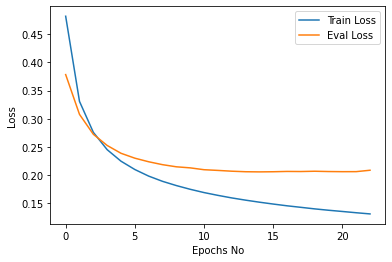

In [45]:
plt.plot(range(args.num_epochs),train_state['train_loss'], label = 'Train Loss')
plt.plot(range(args.num_epochs),train_state['val_loss'], label= 'Eval Loss') 
plt.xlabel("Epochs No")
plt.ylabel("Loss")
plt.legend()

In [76]:
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

print("Most 15 positive words")
print()
for i in range(15):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

print()
print("Most 15 negative words",)
print()
indices.reverse()
for i in range(15):
    print(vectorizer.review_vocab.lookup_index(indices[i]))
    

Most 15 positive words

delicious
amazing
pleasantly
fantastic
yum
excellent
vegas
perfect
great
boba
perfection
goodies
awesome
yummy
hooked

Most 15 negative words

worst
mediocre
rude
bland
awful
horrible
terrible
meh
overpriced
poorly
tasteless
disgusting
downhill
disappointment
unacceptable
